# Применение моделей из Orange
Orange внутри использует Python, а следовательно в голом Python его результаты легко использовать.
Однако, для начала надо установить все необходимые библиотеки.

## Install dependencies
Нам надо установить в Python некоторые библиотеки. Причем некоторые из них надо установить определенных версий.

После того, как ячейка ниже, с установлением зависимостей, добежит вам Colab предложит "Restart Session" - перезапустить среду. Это надо смело сделать. Если вы работаете с этим ноутбуком локально, то просто перезапустите среду.

In [ ]:
!pip install Orange3==3.36.2 Orange3-ImageAnalytics==0.12.2 PyQt5==5.15.10 nest-asyncio diffusers accelerate safetensors transformers numpy==1.25.1 scikit-learn==1.1.3

In [ ]:
# Также нужно немного магии. Без нее в Jupyter Notebook'е код не заводится
import nest_asyncio
nest_asyncio.apply()

## Загрузка наших моделей
Чтобы использовать классификатор стилей и предсказатель стоимости, которые мы обучили ранее их надо загрузить в Colab (а если работаете локально, то ничего делать не надо).

Откройте в левой панельке значек файловой системы. И перетащите в это пространство два файла:
* `price_predictor.pkcls`
* `style_classifier.pkcls`

Их загрузка займет какое-то время, а мы пока пойдем далее.

## Определение функций
Внутри Orange все функции (кроме тех, что мы сами определяем при задавании новых переменных) уже написаны за нас.
Чтобы в Python воспользоваться результатами, которые мы получили в Orange нам надо научиться:
1. Получать эмбеддинги от картинки
1. Загружать обученную модель и применять ее к эмбеддингам
1. Загружать картинку в Python (для визуализаций)

In [29]:
import numpy as np
import pickle
from PIL import Image
from orangecontrib.imageanalytics.image_embedder import ImageEmbedder
from typing import List
import matplotlib.pyplot as plt
%matplotlib inline


def show_img(image: np.ndarray, prompt=''):
    plt.imshow(image)
    plt.title(prompt)
    plt.axis('off')
    plt.show()


def get_img(img_path: str) -> np.ndarray:
    return np.array(Image.open(img_path))


def prettify_price(price: float):
    return "${:,.2f}".format(price)


def get_embeddings(img_paths: List[str]):
    with ImageEmbedder(model='painters') as emb:
        emb.clear_cache()
        return emb(img_paths)


def get_style_prediction(img_paths: str, class_as_str: bool = False, model_path='./style_classifier.pkcls'):
    # Берем эмбеддинги от картинок
    emb = get_embeddings(img_paths)

    # Загружаем модель и получаем стиль - предсказание обученного классификатора
    model = pickle.load(open(model_path, 'rb'))
    style_classes = model(emb)

    # Можно еще научиться выводить уверенность предсказания (оценки вероятностей)
    style_probs = ...

    # Переводим классы из чиселок в текстовое представление
    if class_as_str:
        return [model.domain.class_var.str_val(i) for i in style_classes]
    return style_classes


def get_price_prediction(img_paths: List[str], model_path='price_predictor.pkcls'):
    # Берем эмбеддинги от картинок
    emb = get_embeddings(img_paths)

    # Загружаем модель и получаем предсказание - log_normalized_price
    model = pickle.load(open(model_path, 'rb'))
    pred_log_price = model(emb)

    # Чтобы получить цену в долларах, а не в попугаях - надо пропотенциировать ее по основанию `e`
    return np.e ** pred_log_price

# Применение
Ну, все готово для того, чтобы загрузить какую-то свою картинку и предсказать для нее стиль, в котором она написана и ее цену на аукционе.

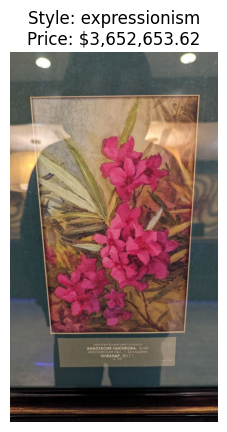

In [46]:
from IPython.display import clear_output

img_path = './example.jpg'
img = get_img(img_path)

print('Загружена картинка:', img_path)
show_img(img)

# Prediction price
price = get_price_prediction([img_path])
price = prettify_price(price[0])

# Prediction style class
style = get_style_prediction([img_path], class_as_str=True, model_path='./../day3/style_classifier.pkcls')[0]

# Make cool title
title = f'Style: {style}\nPrice: {price}'

clear_output(wait=True)
show_img(img, title)